## Importing basic libraries

In [325]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import plotly.express as px
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

## Previewing and analysing dataset

In [287]:
df=pd.read_csv('linkedin-reviews.csv')
df.head()

,Review,Rating
0,Does absolutely nothing for a LinkedIn beginne...,1
1,Force close(galaxy tab),1
2,Slow and it tries to upload your contacts with...,1
3,Add ability to customize the profile and move ...,4
4,"Good app, but it's a pain that it's not possib...",4


In [288]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  702 non-null    object
 1   Rating  702 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.1+ KB


In [289]:
df.isnull().sum()

Review    0
Rating    0
dtype: int64

In [290]:
df['Length'] = df['Review'].apply(len)

In [291]:
df.sample(10)

,Review,Rating,Length
14,Lame. May try it again later when it has more ...,1,92
485,"Pointless, not enough functionality, having to...",1,130
582,All good,5,8
24,Not working on LG optimus,1,25
286,Excellent interface.... Would have liked an op...,4,80
366,Use to be good for Android. Now takes forever ...,1,54
469,"Like that they tried to make or user friendly,...",3,150
424,Linked's app is simply fantastic. 5 stars,5,41
482,Doesn't even load correctly on samsung vibrant...,1,103
495,Keeps crashing on MT4G TMO,1,26


In [292]:
df['Rating'].value_counts()

Rating
1    275
4    122
3    121
5     95
2     89
Name: count, dtype: int64

## total positive review percentage:
#### let us consider 4 and 5 as positive reviews
#### 30.91%
#### let us consider 3,4 and 5 as positive reviews
#### 48.14%

## Some visualizations

In [330]:
def plot_rating_distribution(df, column_name):
    value_counts = df[column_name].value_counts()
    
    # Custom color theme
    colors = px.colors.qualitative.Plotly
    
    fig = px.bar(
        x=value_counts.index, 
        y=value_counts.values, 
        labels={'x': column_name, 'y': 'Count'}, 
        title=f'{column_name} Distribution',
        color=value_counts.index,  # Use the column values for coloring
        color_discrete_sequence=colors  # Set the color theme
    )
    
    fig.update_layout(showlegend=False)
    fig.show()
plot_rating_distribution(df, 'Rating')

In [295]:
print('Rating value percentage')
percentage=round(df['Rating'].value_counts()/df.shape[0]*100,2)
print(percentage)

Rating value percentage
Rating
1    39.17
4    17.38
3    17.24
5    13.53
2    12.68
Name: count, dtype: float64


In [332]:
def plot_rating_percentage_pie(df, column_name):
    percentage = df[column_name].value_counts(normalize=True) * 100
    
    fig = px.pie(
        values=percentage.values, 
        names=percentage.index, 
        title='Percentage Distribution of Ratings',
        labels={column_name: 'Ratings'}
    )
    
    fig.update_traces(textposition='inside', textinfo='percent+label')
    fig.update_layout(showlegend=True, height=600, width=800)
    fig.show()
plot_rating_percentage_pie(df, 'Rating')

In [297]:
cv=CountVectorizer(stop_words='english')
words=cv.fit_transform(df.Review)

In [298]:
cv.vocabulary_

{'does': 279,
 'absolutely': 20,
 'linkedin': 586,
 'beginner': 106,
 'force': 378,
 'closes': 179,
 'useless': 1128,
 'app': 57,
 'close': 176,
 'galaxy': 410,
 'tab': 1017,
 'slow': 950,
 'tries': 1075,
 'upload': 1117,
 'contacts': 217,
 'asking': 70,
 'wtf': 1195,
 'add': 33,
 'ability': 17,
 'customize': 238,
 'profile': 789,
 'sd': 896,
 'card': 153,
 'star': 974,
 'good': 426,
 'pain': 727,
 'possible': 771,
 'sent': 912,
 'messages': 645,
 'kind': 557,
 'confusing': 203,
 'message': 644,
 'poor': 767,
 'bad': 97,
 'htc': 477,
 'desire': 259,
 'bugged': 139,
 'finally': 368,
 'using': 1133,
 'droidin': 295,
 'rating': 809,
 'thank': 1037,
 'kyle': 559,
 'evo': 327,
 'works': 1187,
 'fine': 370,
 'samsung': 885,
 'captivate': 152,
 'clean': 167,
 'design': 257,
 'limited': 583,
 'features': 357,
 'adding': 35,
 'invites': 532,
 'email': 309,
 'address': 36,
 'book': 121,
 'integration': 520,
 'functionality': 401,
 'uninstalling': 1100,
 'like': 580,
 'group': 434,
 'access': 23,

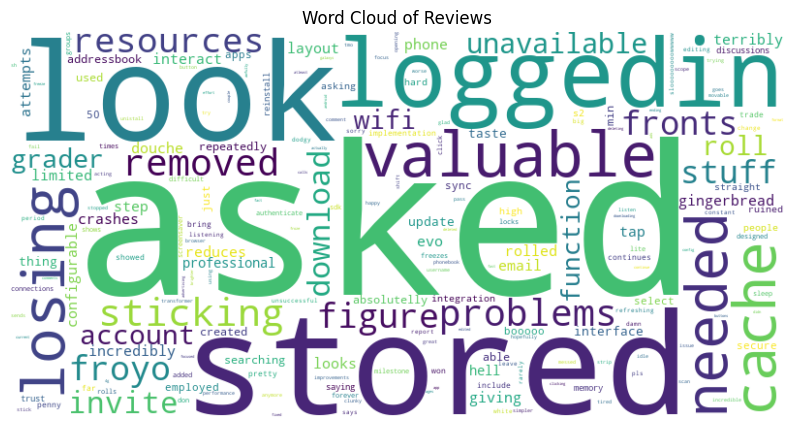

In [339]:
from wordcloud import WordCloud
word_list = cv.get_feature_names_out()
def create_wordcloud(word_list):
# Create a dictionary with word frequencies
    word_freq = dict(zip(word_list, words.sum(axis=0).tolist()[0]))

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    # Display the word cloud
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Reviews')
    plt.show()
create_wordcloud(word_list)


In [300]:
def filter_positive_reviews(df,threshold):
    return  df[df['Rating'] >= threshold]['Review']
def filter_negative_reviews(df,threshold):
    return  df[df['Rating'] <= threshold]['Review']
positive_reviews = filter_positive_reviews(df,3)
negative_reviews = filter_negative_reviews(df,2)

Text(0.5, 1.0, 'Word Cloud of Positive Reviews')

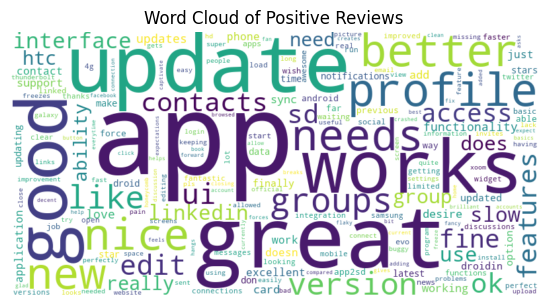

In [341]:
words_positive = cv.fit_transform(positive_reviews)
word_list_positive = cv.get_feature_names_out()
word_freq_positive = dict(zip(word_list_positive, words_positive.sum(axis=0).tolist()[0]))
# Generate word cloud for positive reviews
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_positive)
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Positive Reviews')

Text(0.5, 1.0, 'Word Cloud of Negative Reviews')

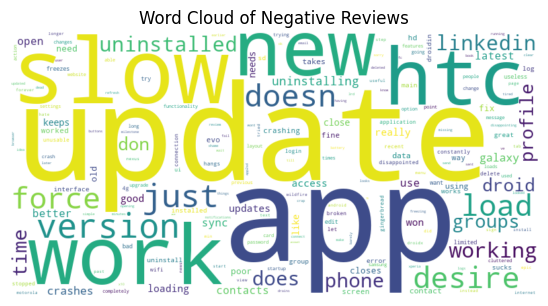

In [302]:
words_negative = cv.fit_transform(negative_reviews)

# Get feature names (words)
word_list_negative = cv.get_feature_names_out()
# Create a dictionary with word frequencies for negative reviews
word_freq_negative = dict(zip(word_list_negative, words_negative.sum(axis=0).tolist()[0]))
# Generate word cloud for negative reviews
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_negative)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_negative)
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Negative Reviews')

## Preprocessing and modelling

In [303]:
lemmatizer=WordNetLemmatizer()

In [304]:
import re
corpus=[]
stemmer=PorterStemmer()
# Preprocess each review
for review in df['Review']:
    # Remove non-alphabetic characters and convert to lowercase
    review = re.sub('[^a-zA-Z]', ' ', review)#remove all characters except alphabets
    review = review.lower().split()#convert to lowercase and split into words
    
    # Apply stemming and remove stopwords
    review = [lemmatizer.lemmatize(word) for word in review if word not in stopwords.words('english')]#remove stopwords and apply lemmatization
    
    # Join the processed words back into a string
    review = ' '.join(review)
    
    # Append the processed review to the corpus
    corpus.append(review)
corpus

['absolutely nothing linkedin beginner force close useless app',
 'force close galaxy tab',
 'slow try upload contact without asking wtf',
 'add ability customize profile move sd card app star one',
 'good app pain possible see sent message kind confusing message sent',
 'app poor bad linkedin app htc desire bugged',
 'finally',
 'using droidin ability move sd card would get star rating thank kyle evo',
 'work fine samsung captivate',
 'clean design limited feature adding invite email address book integration',
 'app work fine limited functionality uninstalling feature like group access',
 'piece app really want people use',
 'simple basic work perfectly main function fast stable',
 'though pay',
 'lame may try later feature sync unnecessary drain battery',
 'nothing special comparing web please enable install sdcard',
 'good start toward emulating program android experienced problem program mighty fine jam fellow',
 'great app better laptop',
 'bad start need feature like upload image

### Creating  bag of words

In [305]:
def label_sentiment(rating):
    if rating >= 3:
        return 'Positive'
    else:
        return 'Negative'
df['Sentiment'] = df['Rating'].apply(label_sentiment)

In [306]:
df.head()

,Review,Rating,Length,Sentiment
0,Does absolutely nothing for a LinkedIn beginne...,1,80,Negative
1,Force close(galaxy tab),1,23,Negative
2,Slow and it tries to upload your contacts with...,1,61,Negative
3,Add ability to customize the profile and move ...,4,90,Positive
4,"Good app, but it's a pain that it's not possib...",4,133,Positive


In [307]:
df['Sentiment'] = df['Sentiment'].map({'Positive': 1, 'Negative': 0})
df

,Review,Rating,Length,Sentiment
0,Does absolutely nothing for a LinkedIn beginne...,1,80,0
1,Force close(galaxy tab),1,23,0
2,Slow and it tries to upload your contacts with...,1,61,0
3,Add ability to customize the profile and move ...,4,90,1
4,"Good app, but it's a pain that it's not possib...",4,133,1
...,...,...,...,...
697,"Can't trust, Going to uninstall just for that ...",1,53,0
698,It really gets me linked in with my friends. H...,5,72,1
699,It lacks most of what makes the other social n...,4,81,1
700,Really disappointed in the new version. Seems ...,2,123,0


In [308]:
tfidf = TfidfVectorizer()

# Fit and transform the corpus to get the TF-IDF representation
X = tfidf.fit_transform(corpus).toarray()
y=df['Sentiment']

In [309]:
print(X.shape)
print(y.shape)

(702, 1164)
(702,)


In [310]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [311]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [312]:
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [313]:
"""classifiers = {
    'LogisticRegression': LogisticRegression(random_state=40, max_iter=10000),
    'RandomForest': RandomForestClassifier(random_state=40),
    'DecisionTree': DecisionTreeClassifier(random_state=40),
    'GradientBoosting': GradientBoostingClassifier(random_state=40),
    'SVM': SVC(random_state=40)
}

# Define parameter grids with simpler configurations
param_grids = {
    'LogisticRegression': {
        'C': [0.1, 1],
        'penalty': ['l2'],  # Use only L2 regularization for simplicity
        'solver': ['liblinear']
    },
    'RandomForest': {
        'n_estimators': [100],
        'max_depth': [None, 10],  # Simplified max_depth parameter
        'min_samples_split': [2, 5]
    },
    'DecisionTree': {
        'max_depth': [None, 10],  # Simplified max_depth parameter
        'min_samples_split': [2, 5]
    },
    'GradientBoosting': {
        'n_estimators': [100],
        'learning_rate': [0.1],  # Simplified learning_rate parameter
        'max_depth': [3, 5]  # Simplified max_depth parameter
    },
    'SVM': {
        'C': [0.01, 1],
        'kernel': ['linear', 'rbf']  # Simplified kernel parameter
    }
}

# Perform grid search and evaluate models
best_estimators = {}
for name, classifier in classifiers.items():
    print(f"Performing Grid Search for {name}")
    grid_search = GridSearchCV(
        estimator=classifier,
        param_grid=param_grids[name],
        cv=3,       # Number of cross-validation folds
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    
    best_estimators[name] = grid_search.best_estimator_
    
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best score for {name}: {grid_search.best_score_}\n")

    # Evaluate the best model on training and test data
    train_accuracy = accuracy_score(y_train, grid_search.best_estimator_.predict(X_train))
    test_accuracy = accuracy_score(y_test, grid_search.best_estimator_.predict(X_test))
    
    print(f"Train accuracy of best {name}: {train_accuracy:.2f}")
    print(f"Test accuracy of best {name}: {test_accuracy:.2f}\n")"""

'classifiers = {\n    \'LogisticRegression\': LogisticRegression(random_state=40, max_iter=10000),\n    \'RandomForest\': RandomForestClassifier(random_state=40),\n    \'DecisionTree\': DecisionTreeClassifier(random_state=40),\n    \'GradientBoosting\': GradientBoostingClassifier(random_state=40),\n    \'SVM\': SVC(random_state=40)\n}\n\n# Define parameter grids with simpler configurations\nparam_grids = {\n    \'LogisticRegression\': {\n        \'C\': [0.1, 1],\n        \'penalty\': [\'l2\'],  # Use only L2 regularization for simplicity\n        \'solver\': [\'liblinear\']\n    },\n    \'RandomForest\': {\n        \'n_estimators\': [100],\n        \'max_depth\': [None, 10],  # Simplified max_depth parameter\n        \'min_samples_split\': [2, 5]\n    },\n    \'DecisionTree\': {\n        \'max_depth\': [None, 10],  # Simplified max_depth parameter\n        \'min_samples_split\': [2, 5]\n    },\n    \'GradientBoosting\': {\n        \'n_estimators\': [100],\n        \'learning_rate\': [0

In [314]:
lr=LogisticRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
print('train_accuracy:',accuracy_score(y_train,lr.predict(X_train)))
print('test_accuracy:',accuracy_score(y_test,y_pred))

train_accuracy: 0.9162210338680927
test_accuracy: 0.7730496453900709


In [315]:
svc=SVC(C=1, kernel='sigmoid', random_state=40)
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
print('train_accuracy',accuracy_score(y_train,svc.predict(X_train)))
print('test_accuracy',accuracy_score(y_test,y_pred))

train_accuracy 0.9001782531194296
test_accuracy 0.7801418439716312


In [316]:
dt=DecisionTreeClassifier(max_depth=10, min_samples_split=2, random_state=40 , criterion='gini')
dt.fit(X_train,y_train)
y_pred=dt.predict(X_test)
print('train_accuracy',accuracy_score(y_train,dt.predict(X_train)))
print('test_accuracy',accuracy_score(y_test,y_pred))

train_accuracy 0.7611408199643493
test_accuracy 0.6737588652482269


In [317]:
rf=RandomForestClassifier(max_depth=20, min_samples_split=2, n_estimators=200,max_features=30,min_samples_leaf=2)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)
print('train_accuracy',accuracy_score(y_train,rf.predict(X_train)))
print('test_accuracy',accuracy_score(y_test,y_pred))

train_accuracy 0.8591800356506238
test_accuracy 0.7659574468085106


In [318]:
from sklearn.naive_bayes import MultinomialNB
mnb=MultinomialNB(alpha=0.1)
mnb.fit(X_train,y_train)
y_pred=mnb.predict(X_test)
print('train_accuracy',accuracy_score(y_train,mnb.predict(X_train)))
print('test_accuracy',accuracy_score(y_test,y_pred))

train_accuracy 0.9518716577540107
test_accuracy 0.8368794326241135


### multinomial naive bayes performs best on the given dataset 

In [319]:
from joblib import dump
dump((mnb, tfidf), 'model_and_tfidf.joblib')

['model_and_tfidf.joblib']

In [320]:
def preprocess_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags if any
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Remove non-alphabetic characters
    text = text.lower()  # Convert to lowercase
    tokens = text.split()  # Split the text into words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

def predict_sentiment(comment):
    # Preprocess the comment
    preprocessed_comment = preprocess_text(comment)
    
    # Transform the preprocessed comment using tfidf vectorizer
    tfidf_vector = tfidf.transform([preprocessed_comment]).toarray()
    
    # Predict the sentiment using the classifier
    predicted_numerical_sentiment = rf.predict(tfidf_vector)[0]  # Assuming clf.predict returns a single prediction
    if predicted_numerical_sentiment == 0:
        predicted_sentiment = 'negative'
    else:
        predicted_sentiment = 'positive'
    return predicted_sentiment

In [321]:
# Example usage:
comment = "i dont love using linkedin"
predicted_sentiment = predict_sentiment(comment)
print(f"Predicted sentiment for the comment '{comment}': {predicted_sentiment}")


Predicted sentiment for the comment 'i dont love using linkedin': negative


In [322]:
"""from tensorflow.keras.layers import Embedding



# Set maximum sequence length
maxlen = 5

# Pad sequences to ensure uniform length
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

# Model parameters
vocab_size = 1500
embedding_dim = 500

# Build the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))
model.add(SimpleRNN(64, activation='relu'))  # First Dense layer
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(Dense(32, activation='relu'))  # Second Dense layer
model.add(Dropout(0.2))  # Dropout layer to prevent overfitting
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')
"""

"from tensorflow.keras.layers import Embedding\n\n\n\n# Set maximum sequence length\nmaxlen = 5\n\n# Pad sequences to ensure uniform length\nX_train = pad_sequences(X_train, maxlen=maxlen)\nX_test = pad_sequences(X_test, maxlen=maxlen)\n\n# Model parameters\nvocab_size = 1500\nembedding_dim = 500\n\n# Build the model\nmodel = Sequential()\nmodel.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim))\nmodel.add(SimpleRNN(64, activation='relu'))  # First Dense layer\nmodel.add(Dropout(0.2))  # Dropout layer to prevent overfitting\nmodel.add(Dense(32, activation='relu'))  # Second Dense layer\nmodel.add(Dropout(0.2))  # Dropout layer to prevent overfitting\nmodel.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification\n# Compile the model\nmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])\n\n# Print model summary\nmodel.summary()\n\n# Train the model\nhistory = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_s